## OPT Trout, 08-01
* MAG 0.5, C mount.
* embedded in 1.5%, 2ECI
* WL transm and FL with blue torch excitation, 590nm LP detections
* 400 steps and undersampling

In [1]:
import sys
import os
import socket
from pathlib import Path
import gc
from time import perf_counter

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import ipywidgets as widgets

from tqdm import tqdm
from scipy.ndimage import variance
from IPython.display import display

import tomopy as tom
from tomopy.recon.rotation import find_center_vo, find_center

import utils_opt as u
from napari_opt_handler.corrections import Correct
from data_loader import OptLoader

%load_ext autoreload
%autoreload 2

In [3]:
# insignificant helper functions
def badcorr3D(data):
    out = np.empty(data.shape)
    for i, img in tqdm(enumerate(data)):
        out[i] = Corr.correctBadPxs(img)
    return out


def move_up(ax, dy):
    pos = ax.get_position()
    ax.set_position([
        pos.x0,
        pos.y0 + dy,
        pos.width,
        pos.height
    ])

## FL LP590

In [3]:
root_folder = Path('/opt/shared/opt_paper_david/raw_data/')

In [4]:
folder = root_folder.joinpath('2024_08_01-fluorescence/2024_08_01-11-22-21_fl_400')
folder_corr = root_folder.joinpath('2024_08_01-fluorescence')

# no WL correction for FL
ddark = cv2.imread(str(folder_corr.joinpath('2024_08_01-12-05-42_dark_field.tiff')), cv2.IMREAD_UNCHANGED)
dhot = cv2.imread(str(folder_corr.joinpath('2024_08_01-12-03-54_corr_hot.tiff')), cv2.IMREAD_UNCHANGED)

In [5]:
try:
    u.rename(folder)
except Exception as e:
    print(e)

In [6]:
stride = 1
# Load folder
opt = OptLoader(folder, depth=np.int16, format='tiff')
opt.load_folder(mode='simple', stride=stride)
n_steps, height, width = opt.data.shape

100%|██████████| 400/400 [00:00<00:00, 493.14it/s]


In [7]:
# widget to select roi
ix0 = widgets.BoundedIntText(value=0, min=0, max=width, step=1, description='x0:', disabled=False)
ix1 = widgets.BoundedIntText(value=1536, min=0, max=width, step=1, description='x1:', disabled=False)
iy0 = widgets.BoundedIntText(value=0, min=0, max=height, step=1, description='y0:', disabled=False)
iy1 = widgets.BoundedIntText(value=2048, min=0, max=height, step=1, description='y1:', disabled=False)

In [8]:
# 360, 1200, y1: 1500
display(ix0), display(ix1)
display(iy0), display(iy1)

# from 25/07/29: 200, 1400, 0, 2047

BoundedIntText(value=0, description='x0:', max=1536)

BoundedIntText(value=1536, description='x1:', max=1536)

BoundedIntText(value=0, description='y0:', max=2048)

BoundedIntText(value=2048, description='y1:', max=2048)

(None, None)

In [9]:
opt.data.shape

(400, 2048, 1536)

In [10]:
hists = u.histogram(opt.data, 'raw')
u.plot_histograms(hists)

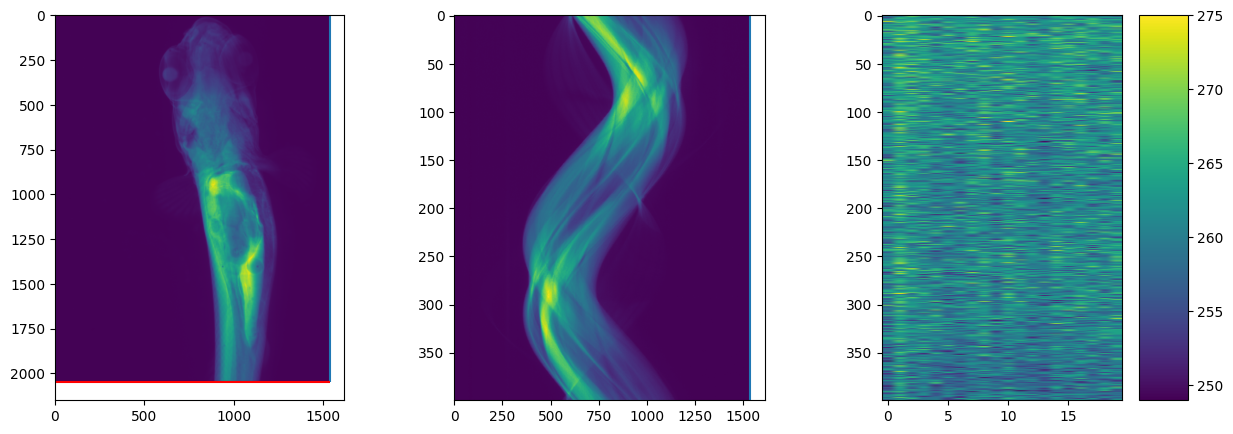

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# --- subplot 1 ---
axs[0].imshow(opt.data[min(100, n_steps-1)])
axs[0].set_aspect(1)
axs[0].vlines([ix0.value, ix1.value], 0, height-1)
axs[0].hlines([iy0.value, iy1.value], 0, width-1, colors='r')

# --- subplot 2 ---
axs[1].imshow(opt.data[:, height//2, :])
axs[1].set_aspect(5)
axs[1].vlines([ix0.value, ix1.value], 0, n_steps-1)

# --- subplot 3 ---
im = axs[2].imshow(opt.data[:, height//2, :20])
axs[2].set_aspect(0.08)
fig.colorbar(im, ax=axs[2], aspect=8)

plt.show()

In [12]:
data = opt.data[:,
                iy0.value:iy1.value,
                ix0.value:ix1.value,
               ]
n_steps, height, width = data.shape

try:
    ddark = ddark[iy0.value:iy1.value,
                  ix0.value:ix1.value,]
except NameError:
    print('You probably do not use DARK')
    
try:
    dhot = dhot[iy0.value:iy1.value,
                ix0.value:ix1.value,]
except NameError:
    print('You probably do not use HOT')
    
try:
    dflat = dflat[iy0.value:iy1.value,
                  ix0.value:ix1.value,]
except NameError:
    print('You probably do not use FLAT')

You probably do not use FLAT


### Correction

In [13]:
try:
    del Corr
except:
    pass
Corr = Correct(std_mult=7)
Corr.set_dark(dark=ddark)
Corr.set_bad(bad=dhot)

#### Dark-Bright correction

In [32]:
gc.collect()
data_corr = Corr.correct_dark_bright(
                data, modality='Emission', useDark=True, useBright=False)

print(f'After Correction max: {np.amax(data_corr)}, min: {np.amin(data_corr)}.')

After Correction max: 3828, min: 0.


In [15]:
hists = u.histogram(data_corr, hist_dict=hists, name='corrected')
u.plot_histograms(hists)

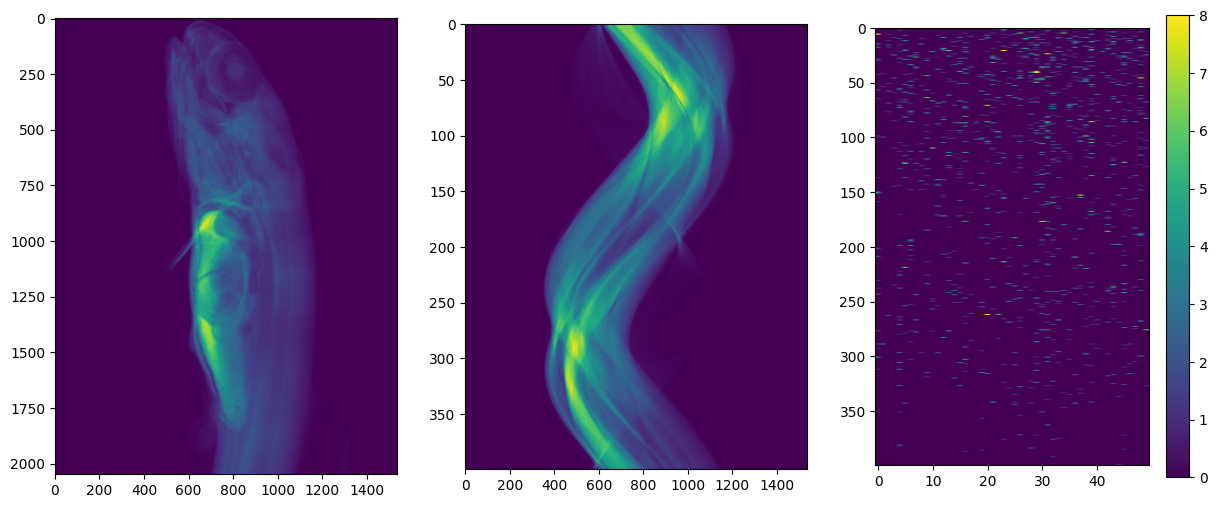

In [33]:
plt.figure(figsize=(15, 6))
plt.subplot(131), plt.imshow(data_corr[0])
plt.subplot(132), plt.imshow(data_corr[:, height//2, :]), plt.gca().set_aspect(5)
plt.subplot(133), plt.imshow(data_corr[:, height//2, :50]), plt.gca().set_aspect(0.2), plt.colorbar()
plt.show()

#### Hot pixel correction

In [34]:
Corr.get_bad_pxs()
print(len(Corr.hot_pxs), len(Corr.dead_pxs))

2923 0


In [36]:
data_corr = badcorr3D(data_corr)

400it [00:12, 31.04it/s]


In [20]:
hists = u.histogram(data_corr, hist_dict=hists, name='bad pixels')
u.plot_histograms(hists)

In [37]:
print(f'After Correction max: {np.amax(data_corr)}, min: {np.amin(data_corr)}.')

After Correction max: 3828.0, min: 0.0.


#### Intensity correction
- To reproduce the paper, select `No` for the fluorescence
- Appropriate correction for the FL is bleaching correction.

In [38]:
intCorr = widgets.Select(
                options=['Yes', 'No'],
                value='Yes',
                rows=2,
                description='Int corr?',
                disabled=False
            )

display(intCorr)

Select(description='Int corr?', options=('Yes', 'No'), rows=2, value='Yes')

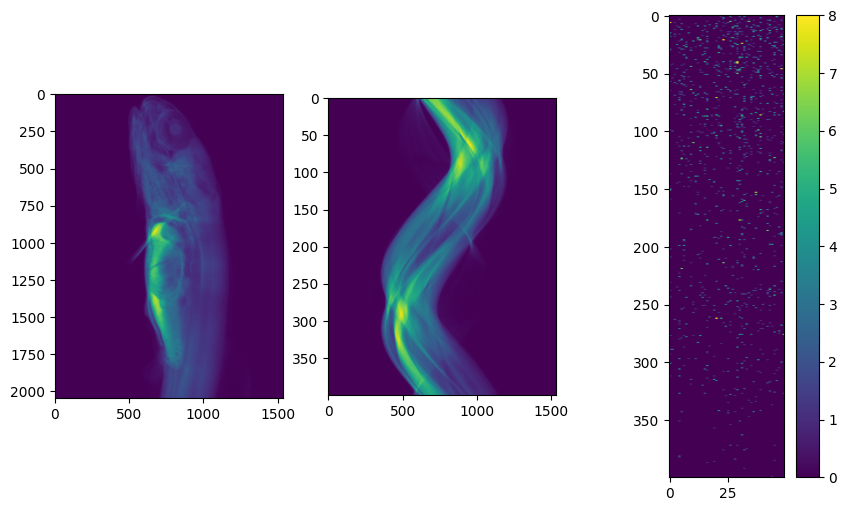

In [39]:
# intensity correction (Without referencing no good for the PL)
if intCorr.value == 'Yes':
    data_corr, report_dict = Corr.correct_int(data_corr, mode='integral',
                                              use_bright=False,
                                              rect_dim=50)
    
    plt.plot(report_dict['stack_orig_int'], label='orig'), 
    plt.plot(report_dict['stack_corr_int'], label='corrected')
    plt.legend()
    plt.show()
    
    print(report_dict['ref'])

plt.figure(figsize=(10, 6))
plt.subplot(131), plt.imshow(data_corr[0])
plt.subplot(132), plt.imshow(data_corr[:, height//2, :]), plt.gca().set_aspect(5)
plt.subplot(133), plt.imshow(data_corr[:, height//2, :50]), plt.gca().set_aspect(0.5), plt.colorbar()
plt.show()

In [40]:
try:
    del data
except:
    print('no data')

try:
    del opt
except:
    print('no opt')

try:
    del full_recon
except:
    print('no full_recon')

n_steps = data_corr.shape[0]
height, width = data_corr.shape[1], data_corr.shape[2]

no full_recon


#### Correcting for FL bleaching

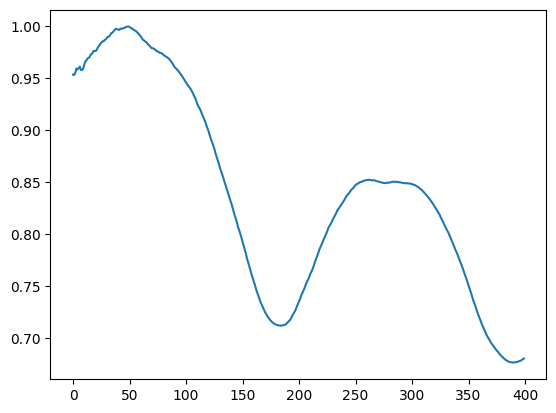

In [ ]:
# avoid plotting 1000s of curves
# run this only if you stride in rows a lot
meanOverColumns = data_corr.mean(axis=2).T
for i, sino in enumerate(meanOverColumns[::100]):
    plt.plot(sino/max(sino), label=i)


plt.legend()
plt.xlabel('OPT step')
plt.ylabel('Norm. detected intensity per line')
plt.title('change in transmitted intensity per line')
plt.show()

# the same but averaged over all the lines
plt.plot(meanOverColumns.mean(axis=0)/max(meanOverColumns.mean(axis=0)))

In [42]:
decay = meanOverColumns.mean(axis=0)/max(meanOverColumns.mean(axis=0))
data_corr = np.divide(data_corr.T, decay).T

plt.figure(figsize=(10, 6))
plt.subplot(131), plt.imshow(data_corr[0])
plt.subplot(132), plt.imshow(data_corr[:, data_corr.shape[1]//2, :]), plt.gca().set_aspect(5)
plt.subplot(133), plt.imshow(data_corr[:, data_corr.shape[1]//2, :50]), plt.gca().set_aspect(0.3), plt.colorbar()
plt.show()

In [45]:
del decay
del meanOverColumns
gc.collect()

47704

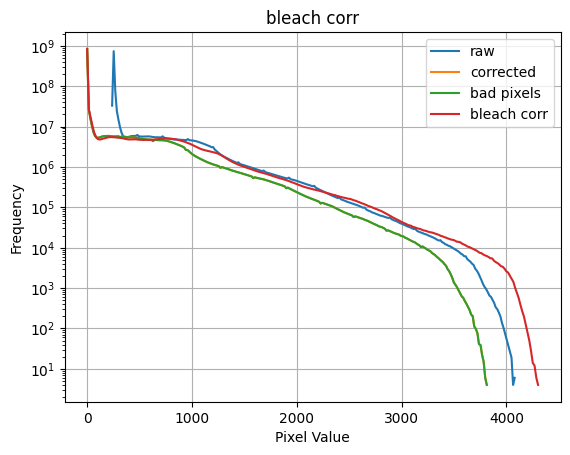

In [46]:
hists = u.histogram(data_corr, hist_dict=hists, name='bleach corr')
u.plot_histograms(hists)

### Clip based on the histogram

In [47]:
np.sum(data_corr > 4000), np.amax(data_corr)

(np.int64(13532), np.float64(4319.285327849442))

In [48]:
# count zeros in data_corr
print(np.sum(data_corr == 0), np.sum(data_corr < 0))

693171782 0


### COR reconstruction

In [52]:
options = {'proj_type': 'cuda', 'method': 'FBP_CUDA'}
n_steps, height, _ = data_corr.shape
thetas = u.calc_thetas(n_steps, half=False)
np.amax(data_corr), np.amin(data_corr)

(np.float64(4319.285327849442), np.float64(0.0))

In [ ]:
beg = perf_counter()
var_fbp_cuda = []
cors = np.arange(770, 787, 1)
for cor in cors:
    recon_fbp_cuda = tom.recon(data_corr[:, 50::100, :],
                        thetas,
                        center=cor,
                        algorithm=tom.astra,
                        options=options,
                        ncore=1)
    recon_fbp_cuda = tom.circ_mask(recon_fbp_cuda, axis=0, ratio=0.90)


    var_fbp_cuda.append(np.sum([variance(k) for k in recon_fbp_cuda]))
    print(cor, end='\r')

end = perf_counter()
print()
print(f"Execution time: {np.round(end-beg, 2)} s")
print('######################')
print(f"index of the maximum variance: {np.argmax(var_fbp_cuda)}, COR value: {cors[np.argmax(var_fbp_cuda)]}")

786
Execution time: 4.1 s
######################
index of the maximum variance: 9, COR value: 779


### Plot variance of stack

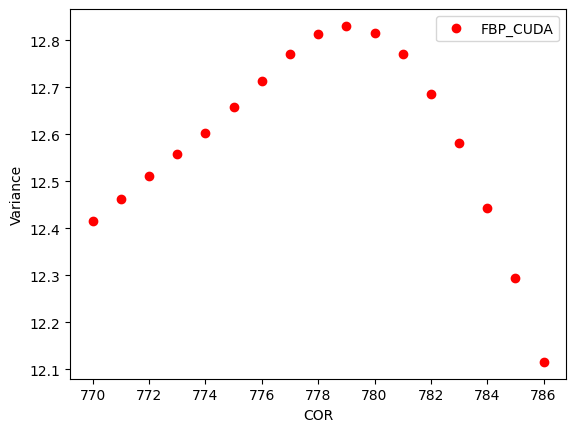

In [61]:
plt.plot(cors, var_fbp_cuda, 'ro', label=options['method'])
plt.xlabel('COR')
plt.ylabel('Variance')
plt.legend()
plt.show()

In [62]:
beg=perf_counter()
recon_fbp_cuda = tom.recon(data_corr,
                    thetas,
                    center=779,
                    algorithm=tom.astra,
                    options=options,
                    ncore=1)
recon_fbp_cuda = tom.circ_mask(recon_fbp_cuda, axis=0, ratio=0.950)
end = perf_counter()
print(f"Execution time: {np.round(end-beg, 2)} s")

# clip negative values
recon_fbp_cuda = np.maximum(recon_fbp_cuda, 0)

# del data_corr
gc.collect()

Execution time: 19.17 s


30875

In [63]:
recon_fbp_cuda.shape, np.amax(recon_fbp_cuda), np.amin(recon_fbp_cuda)

((2048, 1536, 1536), np.float32(17.35943), np.float32(0.0))

min max of reconstructions: 0.0 17.35943


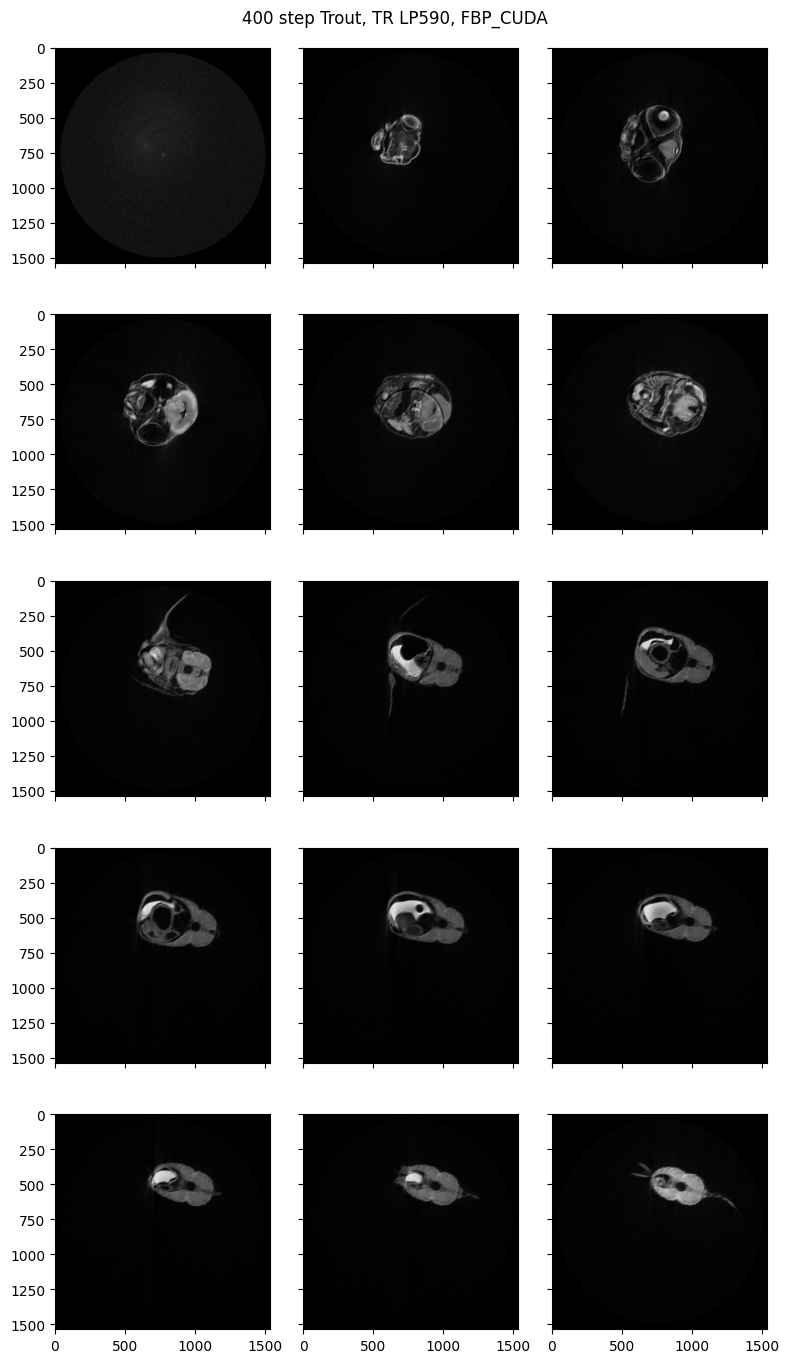

In [64]:
height = recon_fbp_cuda.shape[0]
fig, ax = plt.subplots(5, 3, figsize=(8, 14), sharex=True, sharey=True)
lineidx = []
print('min max of reconstructions:',
      np.amin(recon_fbp_cuda),
      np.amax(recon_fbp_cuda))

for i in range(len(recon_fbp_cuda)):
    
    try:
        ax[i//3, i%3].imshow(recon_fbp_cuda[int(height/15*i)], cmap=plt.cm.Greys_r)
        # ax[i//3, i%3].set_title(i)
        lineidx.append(int(height/15*i))
    except:
        pass
plt.suptitle('400 step Trout, TR LP590, FBP_CUDA')
plt.tight_layout()
# plt.savefig('../fig_output/0801_trout_fbp-cuda_400_tr_lp590.png', dpi=180)
plt.show()

### Normalized plot

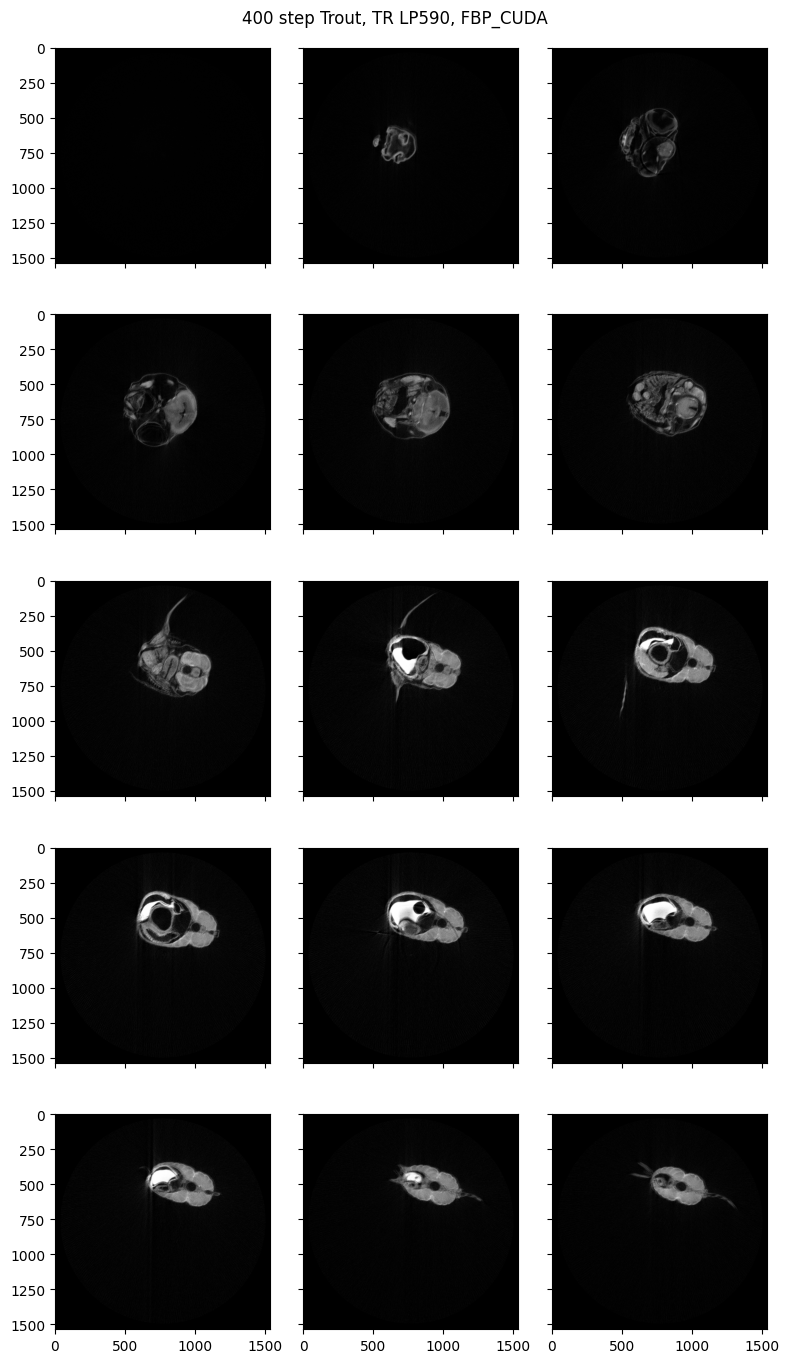

In [ ]:
# Saturation factor
saturation_factor = 2
# same but normalize
cmax = np.amax(recon_fbp_cuda)
cmin = np.amin(recon_fbp_cuda)
height = recon_fbp_cuda.shape[0]
fig, ax = plt.subplots(5, 3, figsize=(8, 14), sharex=True, sharey=True)

for i in range(len(recon_fbp_cuda)):
    try:
        ax[i//3, i%3].imshow(recon_fbp_cuda[int(height/15*i)],
                             cmap=plt.cm.Greys_r,
                             vmin=cmin, vmax=cmax / saturation_factor)
        # ax[i//3, i%3].set_title(i)
    except:
        pass
plt.suptitle('400 step Trout, TR LP590, FBP_CUDA')
plt.tight_layout()
# plt.savefig('../fig_output/0725_trout_fbp-cuda_400_fl_lp590_same_cscale.png', dpi=180)
plt.show()

### Paper figure

In [ ]:
lineidx = [200, 1000, 1500]
recon_fbp_cuda.shape

(2048, 1536, 1536)

In [89]:
# max projection alone

maxproj= np.max(recon_fbp_cuda, axis=2)
minproj= np.min(recon_fbp_cuda, axis=2)
print(np.amin(minproj), np.amax(minproj))
meanproj= np.mean(recon_fbp_cuda, axis=2)

# normalization step
data = [recon_fbp_cuda[k] for k in lineidx]
# data = [u.norm2d(k) for k in data]
# data = [np.clip(k, a_min=0, a_max=4095) for k in data]

0.0 0.0


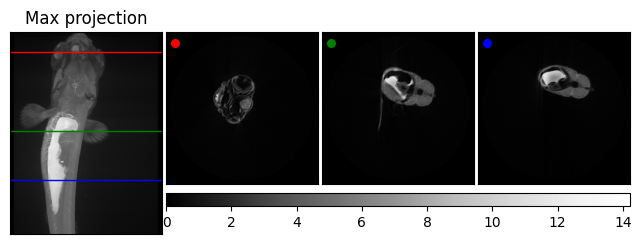

(np.float32(14.2191105), np.float32(0.0))

In [ ]:
import matplotlib.gridspec as gridspec
# fig, ax = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=False)

fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(
    2, 4,
    height_ratios=[1.0, 0.032],
    width_ratios=[1.3, 1.3, 1.3, 1.3],
    hspace=-0.5
)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])
cax = fig.add_subplot(gs[1, 1:])


ax0.imshow(maxproj, cmap=plt.cm.Greys_r)
ax0.axhline(lineidx[0], color='r', lw=1, label='_nolegend_')
ax0.axhline(lineidx[1], color='g', lw=1, label='_nolegend_')
ax0.axhline(lineidx[2], color='b', lw=1, label='_nolegend_')
ax0.set_title('Max projection')
ax0.set_yticks([]), ax0.set_xticks([])


ax1.imshow(data[0], cmap=plt.cm.Greys_r)
ax1.scatter(90, 110, color="red", s=30)
ax1.set_yticks([]), ax1.set_xticks([])

ax2.imshow(data[1], cmap=plt.cm.Greys_r)
ax2.scatter(90, 110, color="green", s=30)
ax2.set_yticks([]), ax2.set_xticks([])

im = ax3.imshow(data[2], cmap=plt.cm.Greys_r)
ax3.scatter(90, 110, color="blue", s=30)
ax3.set_yticks([]), ax3.set_xticks([])
cbar = fig.colorbar(
    im,
    cax=cax,
    orientation="horizontal",
)
fig.subplots_adjust(
    hspace=0.02,
    wspace=0.03
)
move_up(ax1, 0.063)
move_up(ax2, 0.063)
move_up(ax3, 0.063)
move_up(cax, 0.09)

# plt.savefig('../fig_output/0801_trout_fbp-cuda_400_tr_lp590_paper.png', dpi=180)
plt.show()
gc.collect()

### Save recons and figure data

In [251]:
# save data
data2save = u.data2saveFormat(recon_fbp_cuda)
sys.getsizeof(data2save), data2save.dtype

: 

In [149]:
with open('../data_output/0801_fl_lp590_400_recon.npy', 'wb') as f:
    np.save(f, data2save)

In [150]:
del recon_fbp_cuda

In [151]:
gc.collect()

0

In [152]:
dict2save = {'max_proj': maxproj,
             'lineidx': lineidx,
             'rescaled_cuts': data}

with open('../data_output/0801_fl_lp590_400_recon_paper_data.npy', 'wb') as f:
    np.save(f, data2save)

## Transmission LP590

In [179]:
folder = root_folder.joinpath('2024_08_01-11-45-31')
folder_corr = root_folder.joinpath('Corrections')

dflat = cv2.imread(str(folder_corr.joinpath('2024_08_01-12-01-01_flat_field.tiff')),
                   cv2.IMREAD_UNCHANGED)
ddark = cv2.imread(str(folder_corr.joinpath('2024_08_01-12-02-29_dark_field.tiff')),
                   cv2.IMREAD_UNCHANGED)
dhot = cv2.imread(str(folder_corr.joinpath('2024_08_01-12-03-54_corr_hot.tiff')),
                  cv2.IMREAD_UNCHANGED)

In [180]:
stride = 1
# Load folder
opt = OptLoader(folder, depth=np.int16, format='tiff')
opt.load_folder(mode='simple', stride=stride)
n_steps, height, width = opt.data.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 110.47it/s]


In [181]:
# widget to select roi
ix0 = widgets.BoundedIntText(value=0, min=0, max=width, step=1,
                             description='x0:', disabled=False)
ix1 = widgets.BoundedIntText(value=1416, min=0, max=width, step=1,
                             description='x1:', disabled=False)
iy0 = widgets.BoundedIntText(value=0, min=0, max=height, step=1,
                             description='y0:', disabled=False)
iy1 = widgets.BoundedIntText(value=2047, min=0, max=height, step=1,
                             description='y1:', disabled=False)

In [182]:
# 340, 1180, y1: 1400
display(ix0), display(ix1)
display(iy0), display(iy1)

BoundedIntText(value=0, description='x0:', max=1536)

BoundedIntText(value=1416, description='x1:', max=1536)

BoundedIntText(value=0, description='y0:', max=2048)

BoundedIntText(value=2047, description='y1:', max=2048)

(None, None)

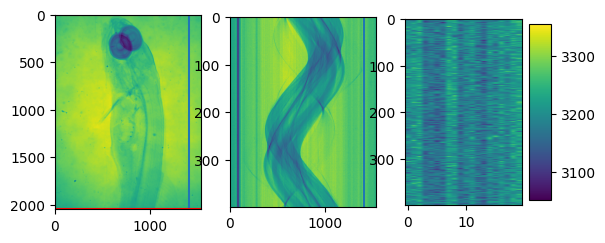

In [183]:
plt.figure()
plt.subplot(131), plt.imshow(opt.data[0])
plt.vlines(ix0.value, 0, height-1)
plt.vlines(ix1.value, 0, height-1)

plt.hlines(iy0.value, 0, width-1, 'r')
plt.hlines(iy1.value, 0, width-1, 'r')

plt.subplot(132), plt.imshow(opt.data[:, height//2, :]), plt.gca().set_aspect(5)
plt.vlines(ix0.value, 0, n_steps-1)
plt.vlines(ix1.value, 0, n_steps-1)
plt.subplot(133), plt.imshow(opt.data[:, height//2, :20]),
plt.colorbar(aspect=8), plt.gca().set_aspect(0.08)
plt.show()

In [184]:
data = opt.data[:,
                iy0.value:iy1.value,
                ix0.value:ix1.value,
               ]
n_steps, height, width = data.shape


In [185]:

try:
    ddark = ddark[iy0.value:iy1.value,
                  ix0.value:ix1.value,]
except NameError:
    print('You probably do not use DARK')
    
try:
    dhot = dhot[iy0.value:iy1.value,
                ix0.value:ix1.value,]
except NameError:
    print('You probably do not use HOT')
    
try:
    dflat = dflat[iy0.value:iy1.value,
                  ix0.value:ix1.value,]
except NameError:
    print('You probably do not use FLAT')

### Saving data

In [186]:
data2save = u.data2saveFormat(data)
sys.getsizeof(data2save), data2save.dtype

(2318841744, dtype('int16'))

In [187]:
with open('../data_output/0801_tr_lp590_400_data_benchmark.npy', 'wb') as f:
    np.save(f, data2save)

In [188]:
del data2save

### Corrections

In [189]:
try:
    del Corr
except:
    pass
gc.collect
Corr = Correct(std_mult=7)
Corr.set_dark(dark=ddark)
Corr.set_bad(bad=dhot)
Corr.set_bright(bright=dflat)

### Dark-Bright correction

In [190]:
data_corr = Corr.correct_dark_bright(
                data, modality='Transmission', useDark=True, useBright=True)

print(f'After Correction max: {np.amax(data_corr)}, min: {np.amin(data_corr)}.')

Overflows 0.17, 1.14, clipping to 0-1.


After Correction max: 65535, min: 11255.


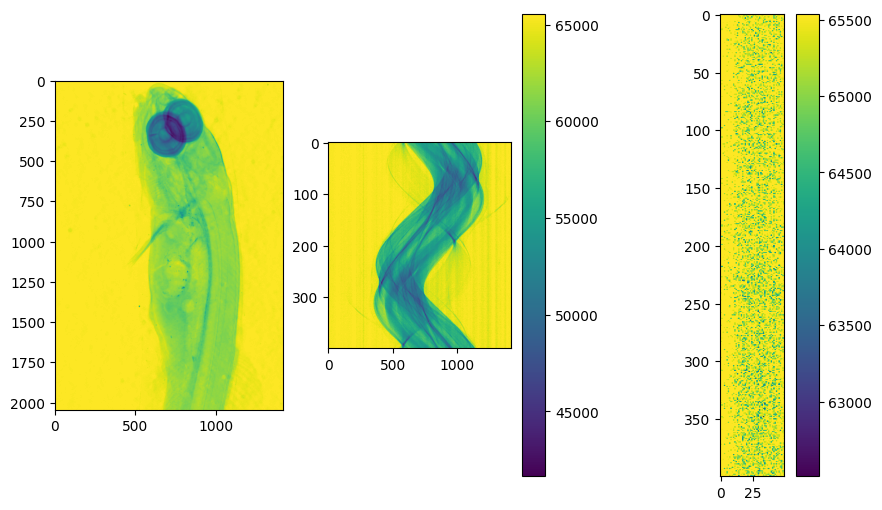

In [191]:
plt.figure(figsize=(10, 6))
plt.subplot(131), plt.imshow(data_corr[0])
plt.subplot(132), plt.imshow(data_corr[:, height//2, :]), plt.gca().set_aspect(4), plt.colorbar()
plt.subplot(133), plt.imshow(data_corr[:, height//2, :50]), plt.gca().set_aspect(0.9), plt.colorbar()
plt.show()

### Intensity correction

In [166]:
intCorr = widgets.Select(
                options=['Yes', 'No'],
                value='Yes',
                rows=2,
                description='Int corr?',
                disabled=False
            )

display(intCorr)

Select(description='Int corr?', options=('Yes', 'No'), rows=2, value='Yes')

Using avg of the corners in the img stack as ref
shape ref: [(50, 50), (50, 50), (50, 50), (50, 50)]


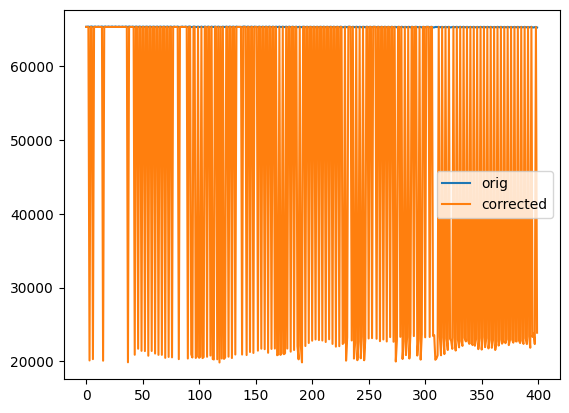

65346.972844


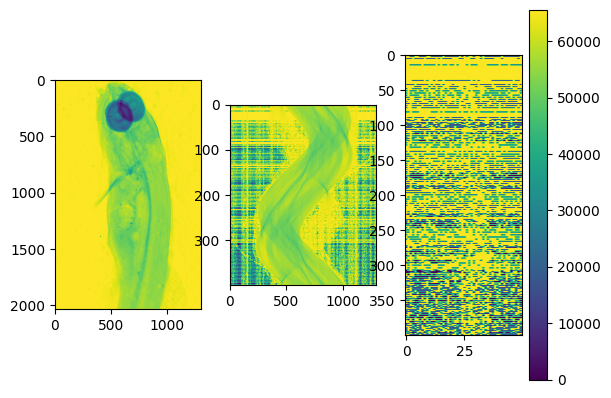

In [237]:
# intensity correction (Without referencing no good for the PL)
if intCorr.value == 'Yes':
    data_corr, report_dict = Corr.correct_int(data_corr, mode='integral',
                                              use_bright=False,
                                              rect_dim=50)
    
    plt.plot(report_dict['stack_orig_int'], label='orig'), 
    plt.plot(report_dict['stack_corr_int'], label='corrected')
    plt.legend()
    plt.show()
    
    print(report_dict['ref'])
    
plt.subplot(131), plt.imshow(data_corr[0])
plt.subplot(132), plt.imshow(data_corr[:, height//2, :]), plt.gca().set_aspect(4)
plt.subplot(133), plt.imshow(data_corr[:, height//2, :50]), plt.gca().set_aspect(0.3), plt.colorbar()
plt.show()
    
    

In [192]:
try:
    del data
except:
    print('no data')

try:
    del opt
except:
    print('no opt')

try:
    del full_recon
except:
    print('no full_recon')

n_steps = data_corr.shape[0]
height, width = data_corr.shape[1], data_corr.shape[2]

no full_recon


### Stride in rows
* reduce dataset

In [193]:
strideRows = widgets.BoundedIntText(
    value=1,
    min=1,
    max=500,
    step=1,
    description='Reduce Rows:',
    disabled=False
)

display(strideRows)

BoundedIntText(value=1, description='Reduce Rows:', max=500, min=1)

In [194]:
if strideRows.value != 1:
    data_corr = data_corr[:, ::strideRows.value, :]
data_corr.shape

(400, 2047, 1416)

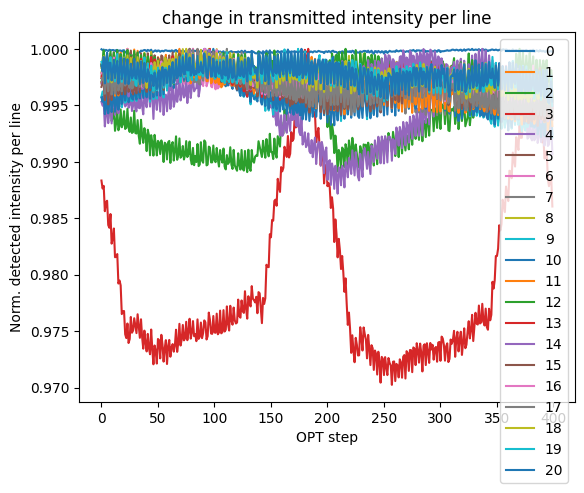

In [195]:
# avoid plotting 1000s of curves
# run this only if you stride in rows a lot
meanOverColumns = data_corr.mean(axis=2).T
if data_corr.shape[1] < 20:
    # I want to see the variation along the sinogram
    for i, sino in enumerate(meanOverColumns):
        plt.plot(sino/max(sino), label=i)
else:
    for i, sino in enumerate(meanOverColumns[::100]):
        plt.plot(sino/max(sino), label=i)


plt.legend()
plt.xlabel('OPT step')
plt.ylabel('Norm. detected intensity per line')
plt.title('change in transmitted intensity per line')
plt.show()

# the same but averaged over all the lines
# plt.plot(meanOverColumns.mean(axis=0)/max(meanOverColumns.mean(axis=0)))

### -log

In [196]:
logCorr = widgets.Select(
                options=['Yes', 'No'],
                value='Yes',
                rows=2,
                description='-log?',
                disabled=False
            )

display(logCorr)

Select(description='-log?', options=('Yes', 'No'), rows=2, value='Yes')

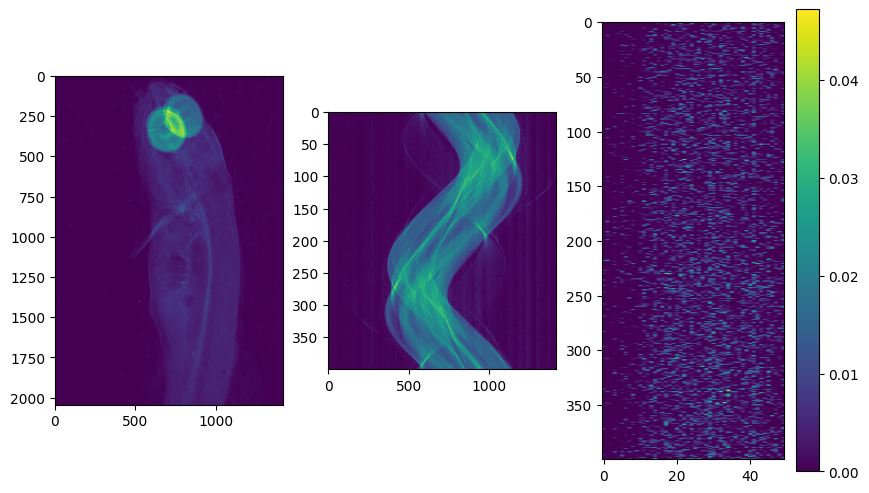

In [197]:
# intensity correction (Without referencing no good for the PL)
if logCorr.value == 'Yes':
    data_corr = tom.minus_log(data_corr, 2)  # two cores
    data_corr = data_corr - np.amin(data_corr)
    
    plt.figure(figsize=(10, 6))
    plt.subplot(131), plt.imshow(data_corr[0])
    plt.subplot(132), plt.imshow(data_corr[:, data_corr.shape[1]//2, :]), plt.gca().set_aspect(4)
    plt.subplot(133), plt.imshow(data_corr[:, data_corr.shape[1]//2, :50]), plt.gca().set_aspect(0.3), plt.colorbar()
    plt.show()

### FBP CUDA reconstruction

In [198]:
options = {'proj_type': 'cuda', 'method': 'FBP_CUDA'}
n_steps, height, _ = data_corr.shape
thetas = u.calc_thetas(n_steps, half=False)
np.amax(data_corr), np.amin(data_corr)

(1.7617722, 0.0)

In [281]:
beg = perf_counter()
var_fbp_cuda = []
cors = np.arange(650, 670, 1)


for cor in cors:
    recon_trfbp_cuda = tom.recon(data_corr,
                        thetas,
                        center=cor,
                        algorithm=tom.astra,
                        options=options,
                        ncore=1)
    recon_trfbp_cuda = tom.circ_mask(recon_trfbp_cuda, axis=0, ratio=0.90)


    var_fbp_cuda.append(np.sum([variance(k) for k in recon_trfbp_cuda]))
    print(cor, var_fbp_cuda, end='\r')  

end = perf_counter()
print()
print(end-beg)

print(np.argmax(var_fbp_cuda), cors[np.argmax(var_fbp_cuda)])

669 [0.0003234141836568289, 0.00032355217213420637, 0.0003237277223939958, 0.00032394868133635334, 0.00032422005121818026, 0.0003245289965094526, 0.0003248958033207913, 0.0003253089181989128, 0.0003257785602833981, 0.0003263105165211643, 0.0003268946677042096, 0.0003274839335671832, 0.0003280337911846979, 0.00032863027710428397, 0.00032929062157428725, 0.0003300117585121576, 0.000330797898671264, 0.0003316379644089111, 0.0003325481753017895, 0.0003335259263153175]
5.80135308302124
19 669


In [282]:
recon_trfbp_cuda.shape, variance(recon_trfbp_cuda)

((21, 1296, 1296), 1.588345401113916e-05)

#### Plot variance of stack

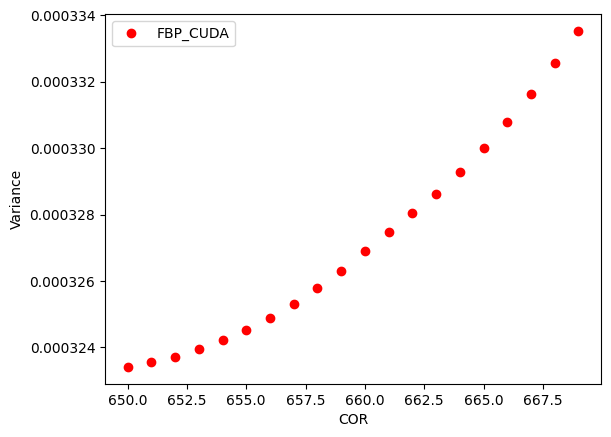

In [283]:
plt.plot(cors, var_fbp_cuda, 'ro', label='FBP_CUDA')
plt.xlabel('COR')
plt.ylabel('Variance')
plt.legend()
plt.show()

### Reconstruction

In [199]:
beg=perf_counter()
recon_trfbp_cuda = tom.recon(data_corr,
                    thetas,
                    center=779,
                    algorithm=tom.astra,
                    options=options,
                    ncore=1)
recon_trfbp_cuda = tom.circ_mask(recon_trfbp_cuda, axis=0, ratio=0.95)

end = perf_counter()
print(end-beg)

del data_corr
gc.collect()

27.113771595002618


39648

min max of reconstructions: -0.011431591 0.082857415


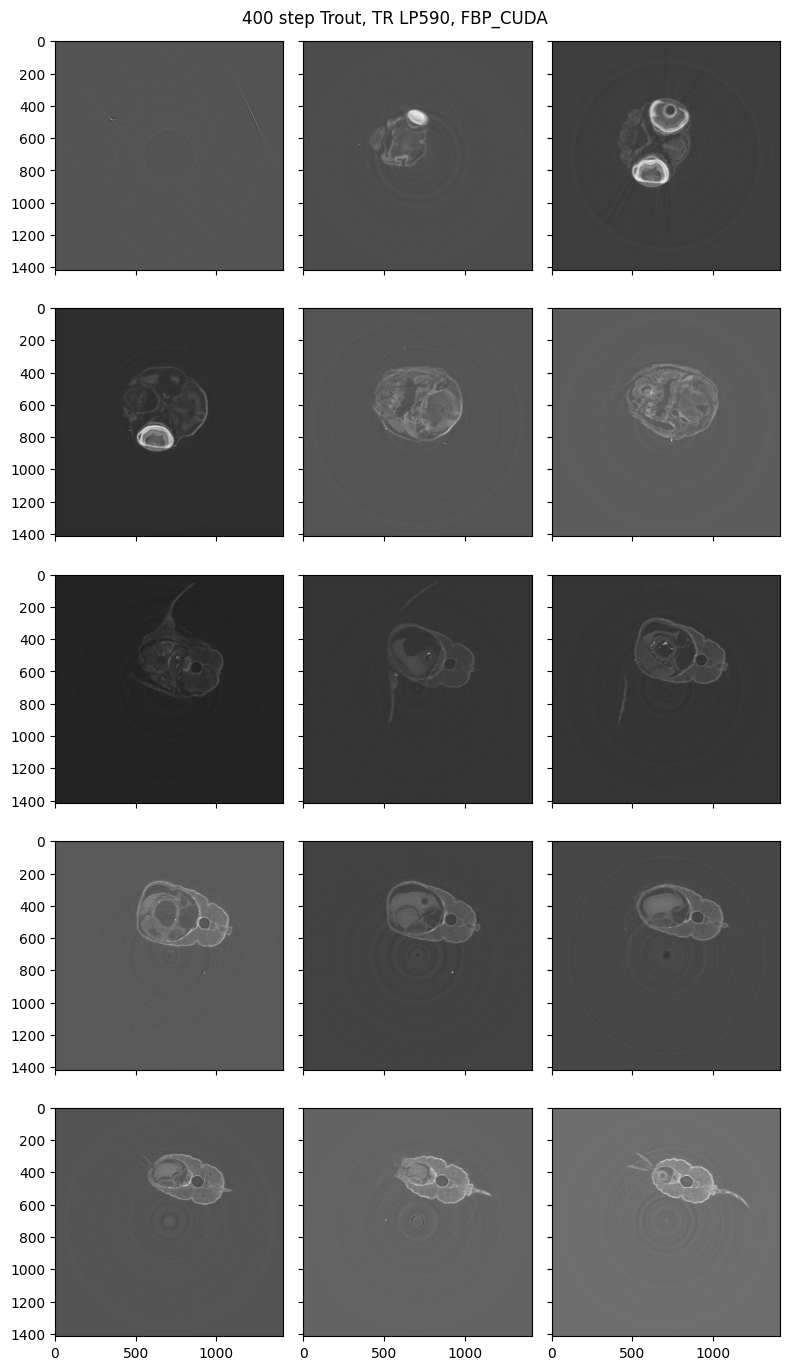

In [200]:
height = recon_trfbp_cuda.shape[0]
fig, ax = plt.subplots(5, 3, figsize=(8, 14), sharex=True, sharey=True)
lineidx = []
print('min max of reconstructions:',
      np.amin(recon_trfbp_cuda),
      np.amax(recon_trfbp_cuda))

for i in range(len(recon_trfbp_cuda)):
    
    try:
        ax[i//3, i%3].imshow(recon_trfbp_cuda[int(height/15*i)], cmap=plt.cm.Greys_r)
        # ax[i//3, i%3].set_title(i)
        lineidx.append(int(height/15*i))
    except:
        pass
plt.suptitle('400 step Trout, TR LP590, FBP_CUDA')
plt.tight_layout()
plt.savefig('../fig_output/0801_trout_fbp-cuda_400_tr_lp590.png', dpi=180)
plt.show()

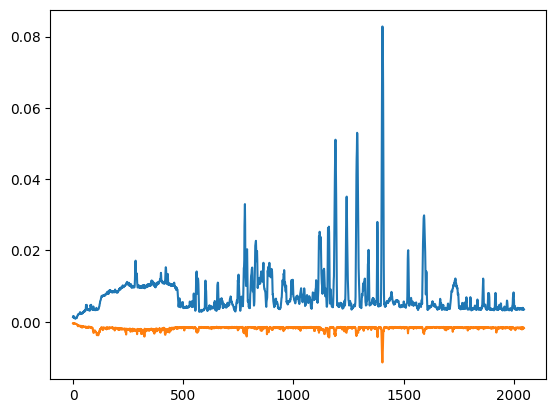

In [201]:
plt.plot(np.amax(recon_trfbp_cuda, axis=(1,2)))
plt.plot(np.amin(recon_trfbp_cuda, axis=(1,2)))

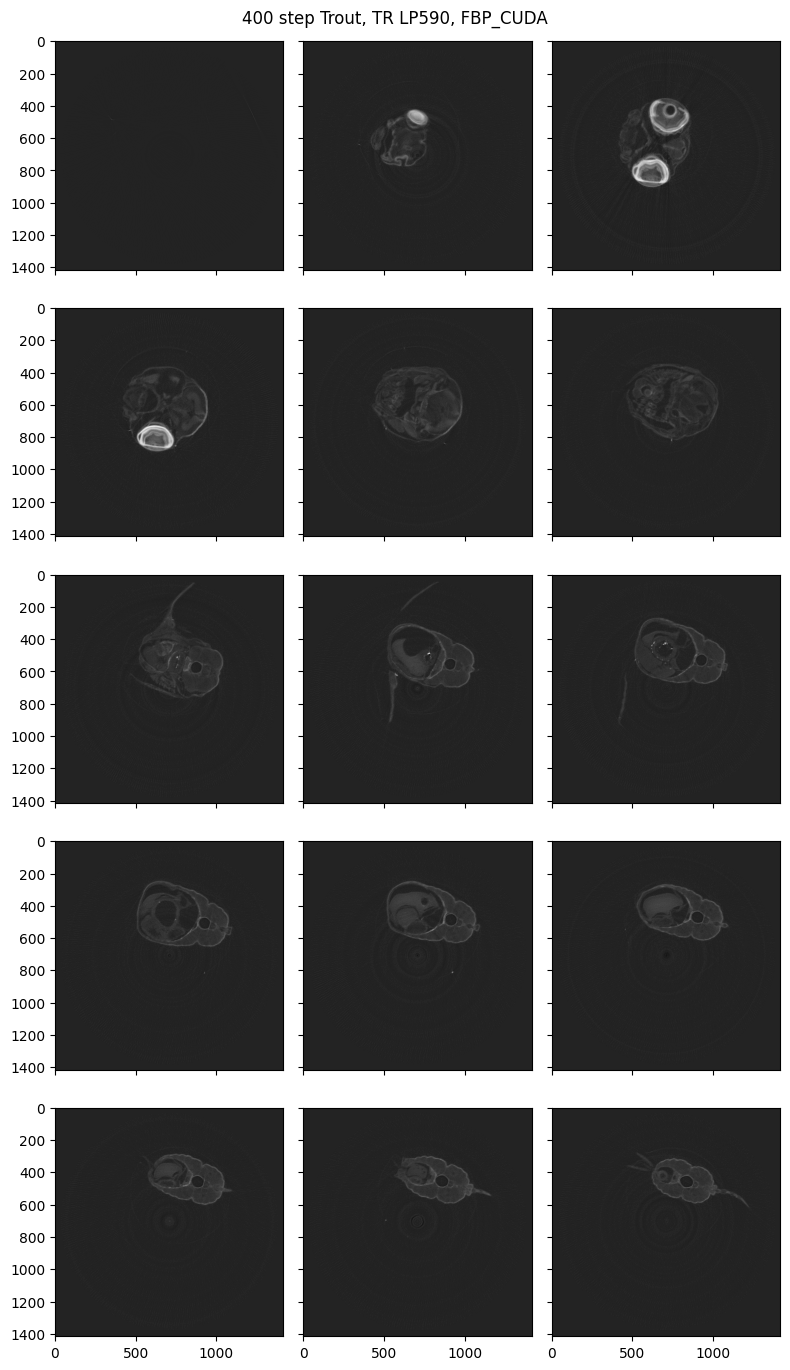

In [203]:
# same but normalize
cmax = np.amax(recon_trfbp_cuda)
cmin = np.amin(recon_trfbp_cuda)
height = recon_trfbp_cuda.shape[0]
fig, ax = plt.subplots(5, 3, figsize=(8, 14), sharex=True, sharey=True)

for i in range(len(recon_trfbp_cuda)):
    try:
        ax[i//3, i%3].imshow(recon_trfbp_cuda[int(height/15*i)],
                             cmap=plt.cm.Greys_r,
                             vmin=cmin/8, vmax=cmax/8)
        # ax[i//3, i%3].set_title(i)
    except:
        pass
plt.suptitle('400 step Trout, TR LP590, FBP_CUDA')
plt.tight_layout()
plt.savefig('../fig_output/0725_trout_fbp-cuda_400_fl_lp590_same_cscale.png', dpi=180)
plt.show()

### Paper figure

In [204]:
if len(recon_trfbp_cuda) > 20:
    lineidx = [200, 1000, 1500]
else:
    lineidx = [3, 6, 9]

# del recon_fbp_cuda
recon_trfbp_cuda.shape

(2047, 1416, 1416)

-0.011431591 0.0


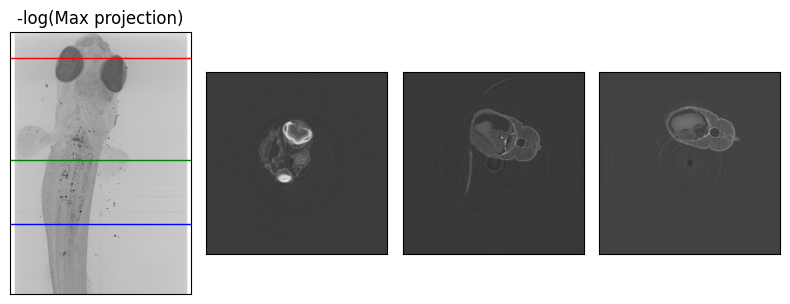

(9.2103405, 2.4894278)

In [ ]:
# max projection alone

maxproj= np.max(recon_trfbp_cuda, axis=2)
minproj= np.min(recon_trfbp_cuda, axis=2)
print(np.amin(minproj), np.amax(minproj))
meanproj= np.mean(recon_trfbp_cuda, axis=2)

# normalization step

data = [recon_trfbp_cuda[k] - np.mean(recon_trfbp_cuda[k][:50, :50]) for k in lineidx]
data = [u.norm2d(k) for k in data]
data = [np.clip(k, a_min=0, a_max=4095) for k in data]



fig, ax = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=False)

ax[0].imshow(tom.minus_log(maxproj+0.0001, 2), vmin=3, vmax=9,
             cmap=plt.cm.Greys_r)
ax[0].axhline(lineidx[0], color='r', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[1], color='g', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[2], color='b', lw=1, label='_nolegend_')
ax[0].set_title('-log(Max projection)')
ax[0].set_yticks([])

ax[1].imshow(data[0], cmap=plt.cm.Greys_r)
ax[1].set_yticks([])
ax[2].imshow(data[1], cmap=plt.cm.Greys_r)
ax[2].set_yticks([])
ax[3].imshow(data[2], cmap=plt.cm.Greys_r)
ax[3].set_yticks([])

plt.xticks([])
# plt.colorbar(om, ax[3])
plt.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.savefig('../fig_output/0801_trout_fbp-cuda_400_tr_lp590_paper.png', dpi=180)
plt.show()
gc.collect()
np.amax(tom.minus_log(maxproj+0.0001, 2)), np.amin(tom.minus_log(maxproj+0.0001, 2))

In [206]:
list(print(np.amin(d), np.amax(d), np.mean(d[:50, :50])) for d in data)

0.0 4095.0 773.09656
0.0 4095.0 740.9092
0.0 4095.0 852.0721


[None, None, None]

## Saving data

In [207]:
# save data
data2save = u.data2saveFormat(recon_trfbp_cuda)
sys.getsizeof(data2save), data2save.dtype

(8208699408, dtype('int16'))

In [208]:
with open('../data_output/0801_tr_lp590_400_recon.npy', 'wb') as f:
    np.save(f, data2save)

In [209]:
del recon_trfbp_cuda

In [210]:
gc.collect()

0

In [211]:
dict2save = {'max_proj': maxproj,
             'lineidx': lineidx,
             'rescaled_cuts': data}

with open('../data_output/0801_tr_lp590_400_recon_paper_data.npy', 'wb') as f:
    np.save(f, data2save)

### FL - TR

In [212]:
tr = np.load('../data_output/0801_tr_lp590_400_recon.npy', allow_pickle=True)
fl = np.load('../data_output/0801_fl_lp590_400_recon.npy', allow_pickle=True)

In [213]:
np.amax(tr), np.amin(tr), np.amax(fl), np.amin(fl)  

(4095, 0, 4095, 0)

In [214]:
tr.shape == fl.shape
diff = tr - fl
np.amax(diff), np.amin(diff)

(2030, -3573)

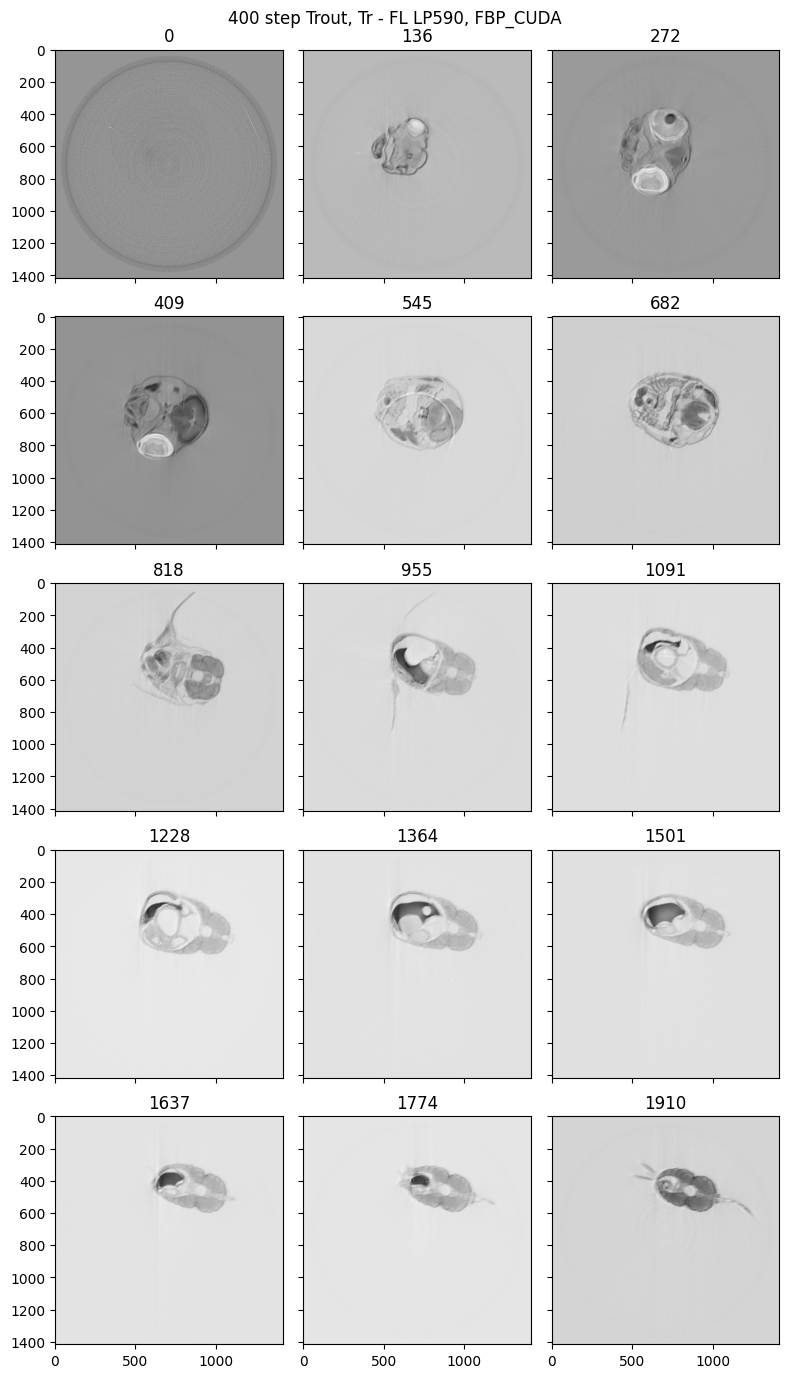

In [296]:
height = tr.shape[0]
fig, ax = plt.subplots(5, 3, figsize=(8, 14), sharex=True, sharey=True)
for i in range(len(tr)):
    try:
        ax[i//3, i%3].imshow(diff[int(height/15*i)], cmap=plt.cm.Greys_r)
        # for the case of stride in rows and plotting everything
        # ax[i//3, i%3].imshow(full_recon[i], cmap=plt.cm.Greys_r)
        ax[i//3, i%3].set_title(int(height/15*i))
    except:
        pass
plt.suptitle('400 step Trout, Tr - FL LP590, FBP_CUDA')
plt.tight_layout()
plt.savefig('../fig_output/0801_tr_fl_diff.png', dpi=180)
plt.show()

### Difference figure for paper from loaded data

In [ ]:
lineidx = [688, 955, 1637]
tr.shape

# max projection alone
maxproj= np.max(tr-fl, axis=2)
minproj= np.min(tr-fl, axis=2)
print('max', np.amin(maxproj), np.amax(maxproj))
print('min', np.amin(minproj), np.amax(minproj))
meanproj= np.mean(tr-fl, axis=2)
# normalization step

data = [tr[k]-fl[k] - np.mean((tr[k]-fl[k])[:50, :50]) for k in lineidx]
data = [u.norm2d(k) for k in data]
data = [np.clip(k, a_min=0, a_max=4095) for k in data]

max -1791 2030
min -3573 -1791


2030 -1791


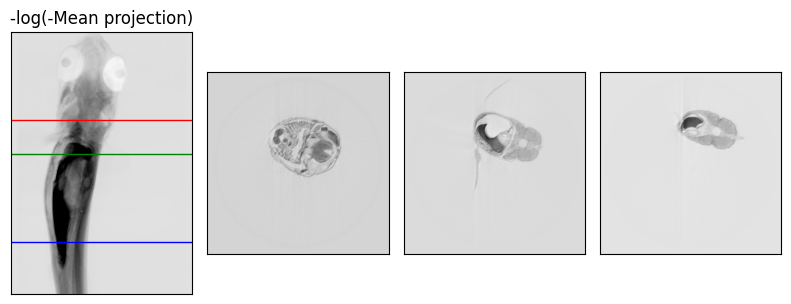

-7.621397 -7.4726887


47286

In [298]:
fig, ax = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=False)
print(np.amax(maxproj),
      np.amin(maxproj))
# ax[0].imshow(meanproj,
#              # vmax=0.5,
#              # vmin=-20,
#              cmap=plt.cm.Greys_r)

ax[0].imshow(tom.minus_log(-meanproj, 2),
             vmin=-7.56,
             # vmax=9,
             cmap=plt.cm.Greys_r)
ax[0].axhline(lineidx[0], color='r', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[1], color='g', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[2], color='b', lw=1, label='_nolegend_')
ax[0].set_title('-log(-Mean projection)')
ax[0].set_yticks([])

ax[1].imshow(data[0], cmap=plt.cm.Greys_r)
ax[1].set_yticks([])
ax[2].imshow(data[1], cmap=plt.cm.Greys_r)
ax[2].set_yticks([])
ax[3].imshow(data[2], cmap=plt.cm.Greys_r)
ax[3].set_yticks([])

plt.xticks([])
# plt.colorbar(om, ax[3])
plt.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.savefig('../fig_output/0801_trout_fbp-cuda_400_tr-fl_lp590_paper01.png', dpi=180, bbox_inches='tight')
plt.show()
print(
np.amin(tom.minus_log(-meanproj, 2)),
np.amax(tom.minus_log(-meanproj, 2)))
gc.collect()

### Transmission figure for paper from loaded data

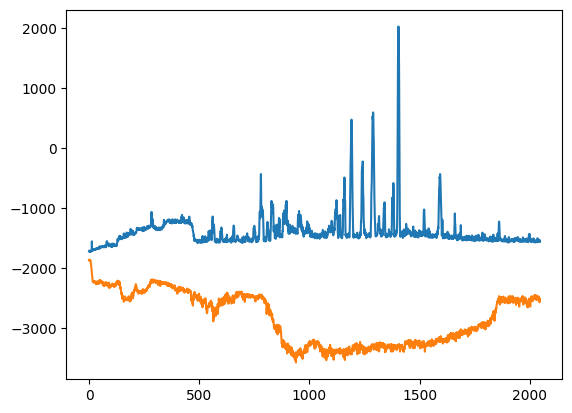

In [238]:
plt.plot(np.amax(tr-fl, axis=(1,2)))
plt.plot(np.amin(tr-fl, axis=(1,2)))

max 496 4095
min 0 496
-6.206576 -8.317522


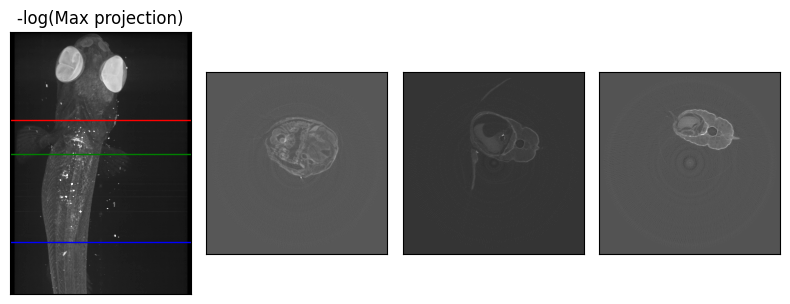

7039

In [ ]:
lineidx = [688, 955, 1637]
tr.shape

# max projection alone
maxproj= np.max(tr, axis=2)
minproj= np.min(tr, axis=2)
print('max', np.amin(maxproj), np.amax(maxproj))
print('min', np.amin(minproj), np.amax(minproj))
meanproj= np.mean(tr, axis=2)
# normalization step

data = [tr[k] - np.mean(tr[k][:50, :50]) for k in lineidx]
data = [u.norm2d(k) for k in data]
data = [np.clip(k, a_min=0, a_max=4095) for k in data]

fig, ax = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=False)
print(np.amax(tom.minus_log(maxproj, 2)),
      np.amin(tom.minus_log(maxproj, 2)))
ax[0].imshow(tom.minus_log(maxproj, 2),
             # vmin=500,
             vmin=-7,
             cmap=plt.cm.Greys)
ax[0].axhline(lineidx[0], color='r', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[1], color='g', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[2], color='b', lw=1, label='_nolegend_')
ax[0].set_title('-log(Max projection)')
ax[0].set_yticks([])

ax[1].imshow(data[0], cmap=plt.cm.Greys_r)
ax[1].set_yticks([])
ax[2].imshow(data[1], cmap=plt.cm.Greys_r)
ax[2].set_yticks([])
ax[3].imshow(data[2], cmap=plt.cm.Greys_r)
ax[3].set_yticks([])

plt.xticks([])
# plt.colorbar(om, ax[3])
plt.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.savefig('../fig_output/0801_trout_fbp-cuda_400_tr_lp590_paper01.png', dpi=180, bbox_inches='tight')
plt.show()
gc.collect()

### FL paper image from loaded data

0 2287
-7.7349963 -8.317522


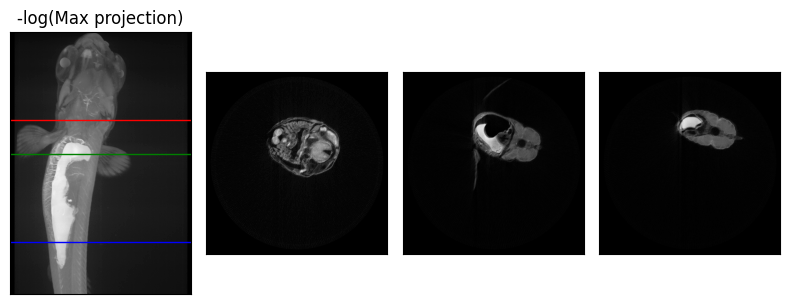

7039

In [ ]:
lineidx = [688, 955, 1637]
fl.shape

# max projection alone
maxproj= np.max(fl, axis=2)
minproj= np.min(fl, axis=2)
print(np.amin(minproj), np.amax(minproj))
meanproj= np.mean(fl, axis=2)
# normalization step

data = [fl[k] - np.mean(fl[k][:50, :50]) for k in lineidx]
data = [np.clip(k, a_min=0, a_max=4095) for k in data]
data = [u.norm2d(k) for k in data]

fig, ax = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=False)
print(np.amax(tom.minus_log(maxproj, 2)), np.amin(tom.minus_log(maxproj, 2)))
ax[0].imshow(tom.minus_log(maxproj, 2), cmap=plt.cm.Greys)
ax[0].axhline(lineidx[0], color='r', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[1], color='g', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[2], color='b', lw=1, label='_nolegend_')
ax[0].set_title('-log(Max projection)')
ax[0].set_yticks([])

ax[1].imshow(data[0], cmap=plt.cm.Greys_r)
ax[1].set_yticks([])
ax[2].imshow(data[1], cmap=plt.cm.Greys_r)
ax[2].set_yticks([])
ax[3].imshow(data[2], cmap=plt.cm.Greys_r)
ax[3].set_yticks([])

plt.xticks([])
# plt.colorbar(om, ax[3])
plt.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.savefig('../fig_output/0801_trout_fbp-cuda_400_fl_lp590_paper01.png', dpi=180, bbox_inches='tight')
plt.show()
gc.collect()